In [28]:
# required packages
from transformers import AutoProcessor, CLIPModel, CLIPTextModel, CLIPVisionModel
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances
from PIL import Image
import glob
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import IncrementalPCA 
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr
from tqdm import tqdm
import time

In [13]:
# Setup cuda device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Defining Models
vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
#combined_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.10.mlp.fc1.weight', 'text_model.encoder.layers.9.mlp.fc2.weight', 'text_model.encoder.layers.11.self_attn.v_proj.weight', 'text_model.encoder.layers.3.self_attn.out_proj.bias', 'text_model.encoder.layers.4.self_attn.out_proj.bias', 'text_model.encoder.layers.8.self_attn.v_proj.bias', 'text_model.encoder.layers.9.mlp.fc1.bias', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.8.mlp.fc2.weight', 'text_model.encoder.layers.10.self_attn.out_proj.weight', 'text_model.encoder.layers.7.self_attn.out_proj.weight', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.6.self_attn.v_proj.weight', 'text_model.encoder.layers.2.layer_norm1.bias', 'text_projection.weight', 'text_model.encoder.layers

In [15]:
# Dataset Classes for Batching
class ImageDataset(Dataset):
    def __init__(self, image_list, processor):
        self.image_list = image_list
        self.processor = processor

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = Image.open(self.image_list[idx])
        image = self.processor(images=image, return_tensors="pt", padding=True)
        return image["pixel_values"].squeeze()

class TextDateset(Dataset):
    def __init__(self, text, processor):
        self.text = processor(text=text, return_tensors="pt", padding=True)

    def __len__(self):
        return len(self.text["input_ids"])

    def __getitem__(self, idx):
        return self.text["input_ids"][idx]

In [5]:
def run_models(captions, image_list, batch_size):
    print("Preparing Dataloaders...")
    # Prepare Dataloaders
    batches = len(image_list) // batch_size
    image_dataset = ImageDataset(image_list, processor)
    text_dataset = TextDateset(captions, processor)
    image_dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=False)
    text_dataloader = DataLoader(text_dataset, batch_size=batch_size, shuffle=False)
    # Extract Features
    print("Extracting Features...")
    vision_features = []
    text_features = []
    with torch.no_grad():
        for i, (image_batch, text_batch) in enumerate(zip(image_dataloader, text_dataloader)):
            print(f"Processing batch {i+1}/{batches}...")
            vision_features.append(vision_model(image_batch, output_hidden_states=True).hidden_states)
            text_features.append(text_model(text_batch, output_hidden_states=True).hidden_states)
    print("Concatenating features...")
    vision_features = tuple(map(torch.cat, zip(*vision_features)))
    text_features = tuple(map(torch.cat, zip(*text_features)))
    return text_features, vision_features 

def generate_rdms(text_features, vision_features):
    text_rdms = []
    vision_rdms = []
    for i, layer in enumerate(text_features):
        text_rdm = euclidean_distances(text_features[i].mean(1).detach().numpy())
        vision_rdm = euclidean_distances(vision_features[i].mean(1).detach().numpy())
        text_rdms.append(text_rdm)
        vision_rdms.append(vision_rdm)
    return text_rdms, vision_rdms

def plot_rdms(text_rdms, vision_rdms, neural_rdm1 = None, neural_rdm2 = None):
    cols = 2
    if neural_rdm1 is not None:
        cols += 1
    if neural_rdm2 is not None:
        cols += 1
    fig, axs = plt.subplots(len(text_rdms), cols, figsize=(50, 50))
    for i, layer in enumerate(text_rdms):
        axs[i, 0].set_title(f"Text RDM - Layer {i+1}")
        axs[i, 0].imshow(text_rdms[i])
        axs[i, 1].set_title(f"Vision RDM - Layer {i+1} ")
        axs[i, 1].imshow(vision_rdms[i])
        if neural_rdm1 is not None:
            axs[i, 2].set_title(f"Neural RDM 1")
            axs[i, 2].imshow(neural_rdm1)
        if neural_rdm2 is not None:
            axs[i, 3].set_title(f"Neural RDM 2")
            axs[i, 3].imshow(neural_rdm2)
    fig.tight_layout()
    plt.show()

def hidden_states_to_csv(text_features, vision_features, image_ids):
    text_dfs = []
    vision_dfs = []
    for i, layer in enumerate(text_features.hidden_states):
        text_df = pd.DataFrame(text_features.hidden_states[i].flatten(1).detach().cpu().numpy())
        vision_df = pd.DataFrame(vision_features.hidden_states[i].flatten(1).detach().cpu().numpy())
        text_df.insert(0, "image_id", image_ids)
        text_df.insert(1, "layer", i+1)
        text_df.insert(2, "model", "text_model")
        vision_df.insert(0, "image_id", image_ids)
        vision_df.insert(1, "layer", i+1)
        vision_df.insert(2, "model", "vision_model")
        text_dfs.append(text_df)
        vision_dfs.append(vision_df)
    text_df = pd.concat(text_dfs)
    vision_df = pd.concat(vision_dfs)
    # create hiden_states folder if it doesn't exist
    if not os.path.exists("hidden_states"):
        os.makedirs("hidden_states")
    text_df.to_csv("hidden_states/text_model_hidden_states.csv", index=False)
    vision_df.to_csv("hidden_states/vision_model_hidden_states.csv", index=False)

def csv_to_hidden_states(path):
    df = pd.read_csv(path)
    hidden_states = {}
    for i in range(len(df["layer"].unique())-1):
        hidden_states[i+1] = []
        cdf = df[df["layer"] == i+1]
        n_rows = cdf.iloc[:, 3:].values.shape[0]
        flattened_shape = cdf.iloc[:, 3:].values.shape[1]
        if (flattened_shape == 11776):
            hidden_states[i+1].append(cdf.iloc[:, 3:].values.reshape(n_rows, 23, 512))
        elif (flattened_shape == 38400):
            hidden_states[i+1].append(cdf.iloc[:, 3:].values.reshape(n_rows, 50, 768))
        else:
            raise ValueError("Unknown hidden state shape")
        hidden_states[i+1] = np.array(hidden_states[i+1]).squeeze()
    return hidden_states

def calculate_rdm_correlations(rdm1, rdm2):
    correlations = []
    if len(rdm1) != 13 and len(rdm1) == len(rdm2):
        print("Calculating correlations between two neural RDM")
        correlations.append(spearmanr(squareform(np.round(rdm1, 5)), squareform(np.round(rdm2[i], 5))))
    elif len(rdm1) == 13 and len(rdm2) != 13:
        print("Calculating correlations between neural RDM and text/vision RDM")
        for i in range(len(rdm1)):
            print(f"Layer {i+1}/{len(rdm1)}")
            correlations.append(spearmanr(squareform(np.round(rdm1[i], 5)), squareform(np.round(rdm2, 5))))
    elif len(rdm1) == 13 and len(rdm2) == 13:
        print("Calculating correlations between two text/vision RDM")
        for i in range(len(rdm1)):
            print(f"Layer {i+1}/{len(rdm1)}")
            correlations.append(spearmanr(squareform(np.round(rdm1[i], 5)), squareform(np.round(rdm2[i], 5))))
    else:
        raise ValueError("Unknown RDM shape")
    return correlations

def plot_correlations(rdm1, rdm2, neural_rdm1 = None, neural_rdm2 = None):
    correlations = calculate_rdm_correlations(rdm1, rdm2)
    if neural_rdm1 is not None:
        correlations_rdm1_neural_rdm1 = calculate_rdm_correlations(rdm1, neural_rdm1)
        correlations_rdm1_neural_rdm2 = calculate_rdm_correlations(rdm1, neural_rdm2)
    if neural_rdm2 is not None:
        correlations_rdm2_neural_rdm1 = calculate_rdm_correlations(rdm2, neural_rdm1)
        correlations_rdm2_neural_rdm2 = calculate_rdm_correlations(rdm2, neural_rdm2)
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title("Correlation between RDMs")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Correlation")
    ax.plot([i+1 for i in range(len(correlations))], [correlations[i][0] for i in range(len(correlations))])
    if neural_rdm1 is not None:
        ax.plot([i+1 for i in range(len(correlations))], [correlations_rdm1_neural_rdm1[i][0] for i in range(len(correlations))])
        ax.plot([i+1 for i in range(len(correlations))], [correlations_rdm1_neural_rdm2[i][0] for i in range(len(correlations))])
    if neural_rdm2 is not None:
        ax.plot([i+1 for i in range(len(correlations))], [correlations_rdm2_neural_rdm1[i][0] for i in range(len(correlations))])
        ax.plot([i+1 for i in range(len(correlations))], [correlations_rdm2_neural_rdm2[i][0] for i in range(len(correlations))])
    # add legend
    legend = ["Text RDM - Vision RDM"]
    if neural_rdm1 is not None:
        legend.append("Text RDM - Neural RDM 1")
        legend.append("Visual RDM - Neural RDM 1")
    if neural_rdm2 is not None:
        legend.append("Text RDM - Neural RDM 2")
        legend.append("Visual RDM - Neural RDM 2")
    ax.legend(legend)
    plt.show()
        

## Testing the model with some coco test images

In [7]:
# Load first 100 images from coco test set
image_list = glob.glob('data/cocotest/*.jpg')[:100]
df = pd.read_csv('data/algonauts_2023_caption_data.csv')
captions = []
for filename in glob.glob('data/cocotest/*.jpg')[:100]:
    im_id = int(filename.split('/')[-1].split('.')[0].split('\\')[-1])
    captions.append(df[df["cocoId"] == im_id]["caption"].values[0])


In [9]:
print("Running models...")
text_features, vision_features = run_models(captions, image_list, 100)

Running models...
Processing batch 1/1...
Concatenating features...


In [262]:
print("Generating RDMs...")
text_rdms, vision_rdms = generate_rdms(text_features, vision_features)

Generating RDMs...


In [ ]:
print("Plotting RDMs...")
plot_rdms(text_rdms, vision_rdms)

In [ ]:
print("Plotting correlations...")
plot_correlations(text_rdms, vision_rdms)

## Running a larger test with subject 1

In [6]:
# Load Image List and captions
image_list = glob.glob('data/training_images/*.png')
captions = []
df = pd.read_csv('data/algonauts_2023_caption_data.csv')
for filename in image_list:
    im_id = int(filename.split('/')[-1].split('.')[0].split('nsd-')[-1])
    captions.append(df[df["nsdId"] == im_id]["caption"].values[0])
print(len(image_list))
print(len(captions))

6721
6721


In [13]:
# Prepare Dataloaders
batch_size = 6721
batches = len(image_list) // batch_size
image_dataset = ImageDataset(image_list, processor)
text_dataset = TextDateset(captions, processor)
image_dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=False)
text_dataloader = DataLoader(text_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Extract Features
vision_features = []
text_features = []
with torch.no_grad():
    for i, (image_batch, text_batch) in enumerate(zip(image_dataloader, text_dataloader)):
        print(f"Processing batch {i+1}/{batches}...")
        vision_features.append(vision_model(image_batch, output_hidden_states=True).hidden_states)
        text_features.append(text_model(text_batch, output_hidden_states=True).hidden_states)
print("Concatenating features...")
vision_features = tuple(map(torch.cat, zip(*vision_features)))
text_features = tuple(map(torch.cat, zip(*text_features)))

Processing batch 1/1...


In [15]:
# Generating RDMs
print("Generating RDMs...")
text_rdms, vision_rdms = generate_rdms(text_features, vision_features)

Generating RDMs...


In [64]:
# load neural data
lh_fmri = np.load('data/training_fmri/lh_training_fmri.npy')
rh_fmri = np.load('data/training_fmri/rh_training_fmri.npy')

In [65]:
# selecting only the images that were downloaded
image_ids = []
for filename in image_list:
    im_id = int(filename.split('/')[-1].split('.')[0].split('_nsd-')[0].split("train-")[1])-1
    image_ids.append(im_id)
lh_fmri = lh_fmri[[image_ids]]
rh_fmri = rh_fmri[[image_ids]]

C:\Users\luke-\AppData\Local\Temp\ipykernel_13440\2137364607.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  lh_fmri = lh_fmri[[image_ids]]
C:\Users\luke-\AppData\Local\Temp\ipykernel_13440\2137364607.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rh_fmri = rh_fmri[[image_ids]]


In [68]:
# Create neural RDMs
lh_neural_rdm = euclidean_distances(lh_fmri)
rh_neural_rdm = euclidean_distances(rh_fmri)


In [ ]:
# Plotting RDMs
print("Plotting RDMs...")
plot_rdms(text_rdms, vision_rdms, lh_neural_rdm, rh_neural_rdm)

Plotting correlations...
Calculating correlations between two text/vision RDM
Layer 1/13
Layer 2/13
Layer 3/13
Layer 4/13
Layer 5/13
Layer 6/13
Layer 7/13
Layer 8/13
Layer 9/13
Layer 10/13
Layer 11/13
Layer 12/13
Layer 13/13
Calculating correlations between neural RDM and text/vision RDM
Layer 1/13
Layer 2/13
Layer 3/13
Layer 4/13
Layer 5/13
Layer 6/13
Layer 7/13
Layer 8/13
Layer 9/13
Layer 10/13
Layer 11/13
Layer 12/13
Layer 13/13
Calculating correlations between neural RDM and text/vision RDM
Layer 1/13
Layer 2/13
Layer 3/13
Layer 4/13
Layer 5/13
Layer 6/13
Layer 7/13
Layer 8/13
Layer 9/13
Layer 10/13
Layer 11/13
Layer 12/13
Layer 13/13
Calculating correlations between neural RDM and text/vision RDM
Layer 1/13
Layer 2/13
Layer 3/13
Layer 4/13
Layer 5/13
Layer 6/13
Layer 7/13
Layer 8/13
Layer 9/13
Layer 10/13
Layer 11/13
Layer 12/13
Layer 13/13
Calculating correlations between neural RDM and text/vision RDM
Layer 1/13
Layer 2/13
Layer 3/13
Layer 4/13
Layer 5/13
Layer 6/13
Layer 7/13
L

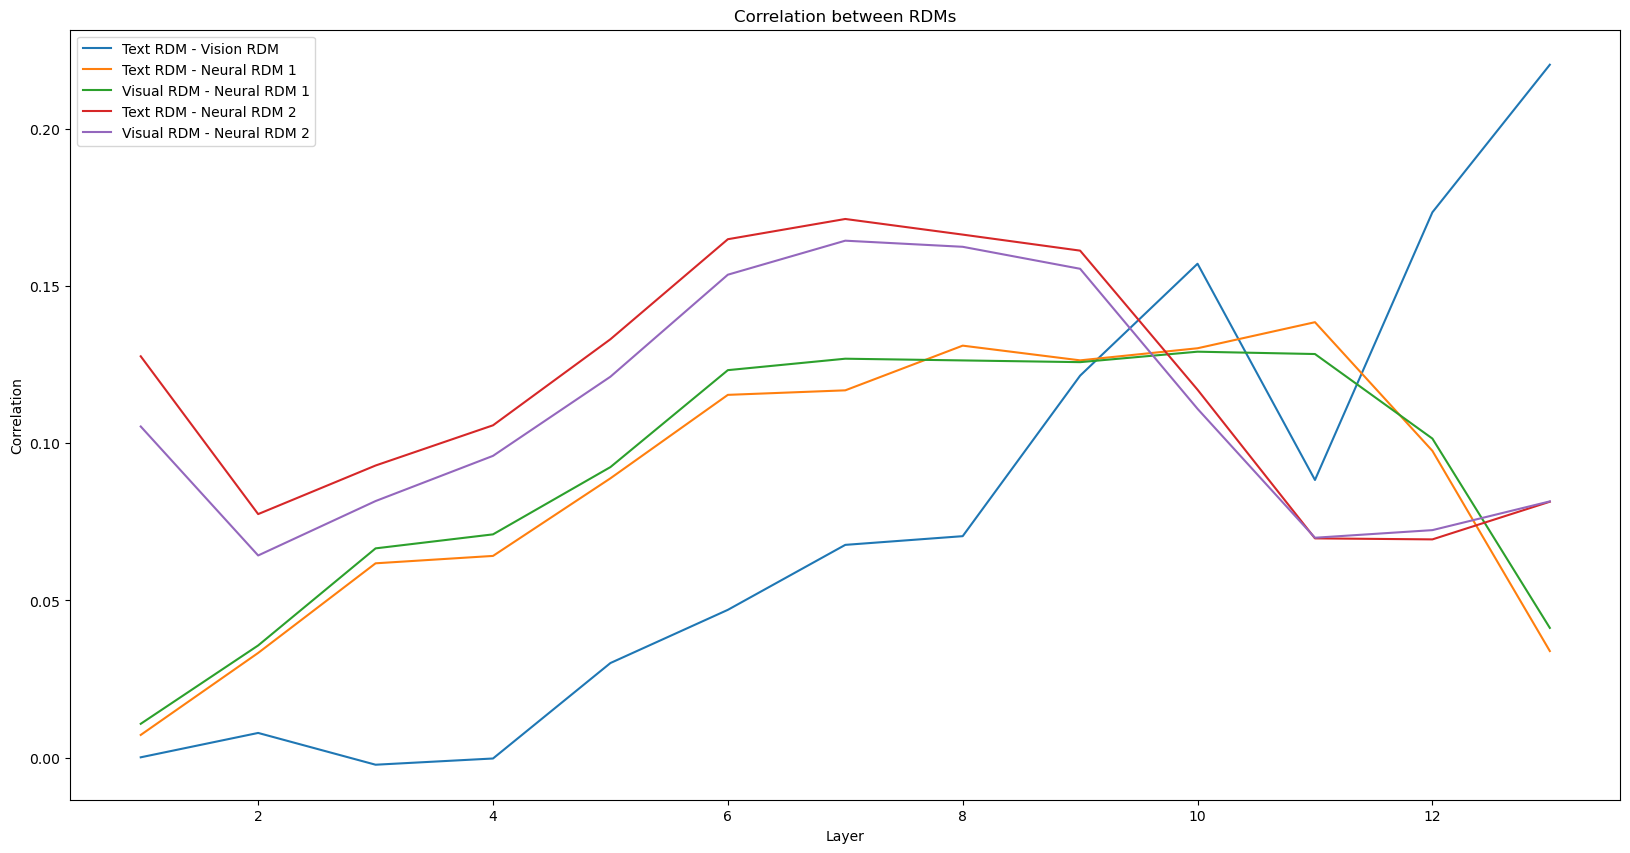

In [85]:
# Plotting Correlations
print("Plotting correlations...")
plot_correlations(text_rdms, vision_rdms, lh_neural_rdm, rh_neural_rdm)

In [93]:
from scipy.optimize import nnls

# get rdvs for betas and y
b1 = squareform(np.round(text_rdms[11], 5))
b2 = squareform(np.round(vision_rdms[11], 5))
b0 = np.ones(b1.shape[0])
y = squareform(np.round(rh_neural_rdm, 5))
DM = np.vstack((b0, b2)).T # create design matrix
B = nnls(DM, y)[0] # get betas
rrdv_R = (DM @ B) # get predicted rdv
corr_reweighted_analysis = spearmanr(y, rrdv_R)[0]
corr_reweighted_analysis

0.07237296745832722

## Copy algonauts tutorial procedure

### Useful functions

#### Utility Functions

In [16]:
def prepare_image_list_and_captions():
    # Used for testing only
    # Loads images and captions from local data folder
    image_list = glob.glob('data/training_images/*.png')
    captions = []
    df = pd.read_csv('data/algonauts_2023_caption_data.csv')
    for filename in image_list:
        im_id = int(filename.split('/')[-1].split('.')[0].split('nsd-')[-1])
        captions.append(df[df["nsdId"] == im_id]["caption"].values[0])
    return image_list, captions

def prepare_data(image_list, captions, batch_size):
    # Creates dataloaders for images and captions
    n = len(image_list)
    batches = n // batch_size
    text_dataset = TextDateset(captions, processor)
    text_dataloader = DataLoader(text_dataset, batch_size=batch_size, shuffle=False)
    vision_dataset = ImageDataset(image_list, processor)
    vision_dataloader = DataLoader(vision_dataset, batch_size=batch_size, shuffle=False)
    return text_dataloader, vision_dataloader, batches

def prepare_layer_dict(keys = ["Embedding Layer", 
                                "Layer 1", 
                                "Layer 2", 
                                "Layer 3", 
                                "Layer 4", 
                                "Layer 5", 
                                "Layer 6", 
                                "Layer 7", 
                                "Layer 8", 
                                "Layer 9", 
                                "Layer 10", 
                                "Layer 11", 
                                "Layer 12", 
                                "Final Layer"]):
    # These dicts are used to store features and pca models
    layer_dict = {key: None for key in keys}
    return layer_dict

def plot_layer_activations(text_features: dict, vision_features: dict):
    fig, axes = plt.subplots(14, 2, figsize=(10, 25))
    for i, layer in enumerate(text_features):
        axes[i, 0].imshow(text_features[layer].mean(1).numpy())
        axes[i, 0].set_title(f"Text Model: {layer}")
    for i, layer in enumerate(vision_features):
        axes[i, 1].imshow(vision_features[layer].mean(1).numpy())
        axes[i, 1].set_title(f"Vision Model: {layer}")
    plt.tight_layout()
    plt.show()


#### PCA Functions

In [17]:
def pca_partial_fit(i, model_output, pca_dict, batch_size, components):
    # Fits PCA model to features
    keys = list(pca_dict.keys())  
    assert len(model_output.hidden_states) + 1 == len(keys), "Number of layers and keys do not match"        
    if i == 0:
        for j in range(len(keys)):
            pca_dict[keys[j]] = IncrementalPCA(n_components=components, batch_size=batch_size)
    for j in range(len(keys)-1):
        pca_dict[keys[j]].partial_fit(model_output.hidden_states[j].flatten(1).detach().cpu().numpy())
    pca_dict[keys[-1]].partial_fit(model_output.last_hidden_state.flatten(1).detach().cpu().numpy())
    return pca_dict

def pca_transform_features(pca_dict, key, hidden_state):
    # Transforms features using PCA model
    assert key in pca_dict.keys(), "Key not in pca_dict"
    return pca_dict[key].transform(hidden_state.flatten(1).detach().cpu().numpy())

def fit_pca(text_model: CLIPTextModel,
            vision_model: CLIPVisionModel,
            text_dataloader: DataLoader,
            vision_dataloader: DataLoader,
            pca_components: int):
    # Prepare pca dicts
    text_pca = prepare_layer_dict()
    vision_pca = prepare_layer_dict()

    # Fit pca
    batch_size = vision_dataloader.batch_size
    batches = len(vision_dataloader)
    if pca_components > batch_size:
        pca_components = batch_size
    with torch.no_grad():
        for i, (image_batch, text_batch) in enumerate(zip(vision_dataloader, text_dataloader)):
            print(f"Processing batch {i+1}/{batches}...")
            # Running Text Model
            txt_output = text_model(text_batch, output_hidden_states=True)
            text_pca = pca_partial_fit(i, txt_output, text_pca, batch_size = batch_size, components = pca_components)
            # Running Vision Model
            vis_output = vision_model(image_batch, output_hidden_states=True)
            vision_pca = pca_partial_fit(i, vis_output, vision_pca, batch_size = batch_size, components = pca_components)
    print(text_pca["Embedding Layer"].n_components_)
    print(vision_pca["Embedding Layer"].n_components_)
    return text_pca, vision_pca

#### Feature Extraction Functions

In [26]:
def concat_features(i, model_output, feature_dict):
    keys = list(feature_dict.keys())  
    assert len(model_output.hidden_states) + 1 == len(keys), "Number of layers and keys do not match"        
    if i == 0:
        for j in range(len(keys)-1):
            feature_dict[keys[j]] = model_output.hidden_states[j]
        feature_dict[keys[-1]] = model_output.last_hidden_state
    else:
        for j in range(len(keys)-1):
            feature_dict[keys[j]] = torch.cat((feature_dict[keys[j]], model_output.hidden_states[j]), dim=0)
        feature_dict[keys[-1]] = torch.cat((feature_dict[keys[-1]], model_output.last_hidden_state), dim=0)
    return feature_dict

def concat_features_pca_transform(i, model_output, feature_dict, pca_dict):
    keys = list(feature_dict.keys())  
    assert len(model_output.hidden_states) + 1 == len(keys), "Number of layers and feature dict keys do not match"
    assert len(model_output.hidden_states) + 1 == len(pca_dict.keys()), "Number of layers and pca dict keys do not match"
    if i == 0:
        for j in range(len(keys)-1):
            hidden_state = model_output.hidden_states[j]
            key = keys[j]
            feature_dict[key] = pca_transform_features(pca_dict, key, hidden_state)
        hidden_state = model_output.last_hidden_state
        key = keys[-1]
        feature_dict[key] = pca_transform_features(pca_dict, key, hidden_state)
    else:
        for j in range(len(keys)-1):
            hidden_state = model_output.hidden_states[j]
            key = keys[j]
            feature_dict[key] = np.concatenate((feature_dict[key], pca_transform_features(pca_dict, key, hidden_state)), 0)
        hidden_state = model_output.last_hidden_state
        key = keys[-1]
        feature_dict[key] = np.concatenate((feature_dict[key], pca_transform_features(pca_dict, key, hidden_state)), 0)
    return feature_dict

def extract_raw_features(text_dataloader: DataLoader,
                          vision_dataloader: DataLoader,
                          text_model: CLIPTextModel,
                          vision_model: CLIPVisionModel):
    # Uses the standard concat_features function to extract the raw hidden layer features

    # Prepare feature dicts
    text_features = prepare_layer_dict()
    vision_features = prepare_layer_dict() 

    # Extract features
    batches = len(vision_dataloader)
    with torch.no_grad():
        for i, (image_batch, text_batch) in enumerate(zip(vision_dataloader, text_dataloader)):
            batch_time = time.time()
            print(f"Processing batch {i+1}/{batches}...")
            # Running Text Model
            txt_output = text_model(text_batch, output_hidden_states=True)
            text_features = concat_features(i, txt_output, text_features)
            # Running Vision Model
            vis_output = vision_model(image_batch, output_hidden_states=True)
            vision_features = concat_features(i, vis_output, vision_features)
            print(f"Batch {i+1}/{batches} took {time.time() - batch_time:.2f} seconds")
            print(f"Predicted time remaining: {(time.time() - batch_time) * (batches - i) / 60:.2f} minutes")
    print(text_features[list(text_features.keys())[0]].shape)
    print(vision_features[list(vision_features.keys())[0]].shape)
    return text_features, vision_features

def extract_pca_features(text_pca: dict, 
                         vision_pca: dict, 
                         text_dataloader: DataLoader, 
                         vision_dataloader: DataLoader, 
                         text_model: CLIPTextModel, 
                         vision_model: CLIPVisionModel):
    # Uses the concat_features_pca_transform function to extract the pca transformed hidden layer features

    # Prepare pca transformed feature dicts
    text_features_pca_transf = prepare_layer_dict()
    vision_features_pca_transf = prepare_layer_dict() 

    # Extract features
    batches = len(vision_dataloader)
    with torch.no_grad():
        for i, (image_batch, text_batch) in enumerate(zip(vision_dataloader, text_dataloader)):
            print(f"Processing batch {i+1}/{batches}...")
            # Running Text Model
            text_output = text_model(text_batch, output_hidden_states=True)
            text_features_pca_transf = concat_features_pca_transform(i, text_output, text_features_pca_transf, text_pca)
            # Running Vision Model
            vision_output = vision_model(image_batch, output_hidden_states=True)
            vision_features_pca_transf = concat_features_pca_transform(i, vision_output, vision_features_pca_transf, vision_pca)
    print(text_features_pca_transf[list(text_features_pca_transf.keys())[0]].shape)
    print(vision_features_pca_transf[list(vision_features_pca_transf.keys())[0]].shape)
    return text_features_pca_transf, vision_features_pca_transf

### Testing with some local data

In [19]:
# Prepare data
batch_size = 50
image_list, captions = prepare_image_list_and_captions()
text_dataloader, vision_dataloader, batches = prepare_data(image_list[:100], captions[:100], batch_size = batch_size)

In [29]:
# Extract raw features
text_features, vision_features = extract_raw_features(text_dataloader, vision_dataloader, text_model, vision_model)
# Fit pca
text_pca, vision_pca = fit_pca(text_model, vision_model, text_dataloader, vision_dataloader, pca_components = 50)
# Extract pca transformed features
text_features_pca_transf, vision_features_pca_transf = extract_pca_features(text_pca, vision_pca, text_dataloader, vision_dataloader, text_model, vision_model)

Processing batch 1/2...
Batch 1/2 took 5.73 seconds
Predicted time remaining: 0.21 minutes
Processing batch 2/2...
Batch 2/2 took 5.44 seconds
Predicted time remaining: 0.20 minutes
torch.Size([100, 28, 512])
torch.Size([100, 50, 768])
Processing batch 1/2...


c:\Users\luke-\anaconda3\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
c:\Users\luke-\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\luke-\anaconda3\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
c:\Users\luke-\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\luke-\anaconda3\lib\site-packages\sklearn\decomposition\_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
c:\Users\luke-\anaconda3\lib\site-packages\numpy\core\_methods.py:189:

Processing batch 2/2...


KeyboardInterrupt: 

In [21]:
# Load Neural data
lh_fmri = np.load('data/training_fmri/lh_training_fmri.npy')
rh_fmri = np.load('data/training_fmri/rh_training_fmri.npy')
# selecting only the images that were part of the test
image_ids = []
for filename in image_list[:100]:
    im_id = int(filename.split('/')[-1].split('.')[0].split('_nsd-')[0].split("train-")[1])-1
    image_ids.append(im_id)
lh_fmri = lh_fmri[[image_ids]]
rh_fmri = rh_fmri[[image_ids]]

C:\Users\luke-\AppData\Local\Temp\ipykernel_29264\4125893739.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  lh_fmri = lh_fmri[[image_ids]]
C:\Users\luke-\AppData\Local\Temp\ipykernel_29264\4125893739.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rh_fmri = rh_fmri[[image_ids]]


In [22]:
# Split in train and validation
text_features_pca_transf_train = text_features_pca_transf["Final Layer"][:80]
text_features_pca_transf_val = text_features_pca_transf["Final Layer"][80:]
lh_fmri_train = lh_fmri[:80]
lh_fmri_val = lh_fmri[80:]
rh_fmri_train = rh_fmri[:80]
rh_fmri_val = rh_fmri[80:] # some change

In [23]:
# Fit linear regressions on the training data
reg_lh = LinearRegression().fit(text_features_pca_transf_train, lh_fmri_train)
reg_rh = LinearRegression().fit(text_features_pca_transf_train, rh_fmri_train)


In [24]:
# Use fitted linear regressions to predict the validation and test fMRI data
lh_fmri_val_pred = reg_lh.predict(text_features_pca_transf_val)
rh_fmri_val_pred = reg_rh.predict(text_features_pca_transf_val)

In [25]:
# Empty correlation array of shape: (LH vertices)
lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
# Correlate each predicted LH vertex with the corresponding ground truth vertex
for v in tqdm(range(lh_fmri_val_pred.shape[1])):
    lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]
lh_median_correlation = [np.median(lh_correlation[r]) for r in range(len(lh_correlation))]

# Empty correlation array of shape: (RH vertices)
rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
# Correlate each predicted RH vertex with the corresponding ground truth vertex
for v in tqdm(range(rh_fmri_val_pred.shape[1])):
    rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]
rh_median_correlation = [np.median(rh_correlation[r]) for r in range(len(rh_correlation))]    

100%|██████████| 20544/20544 [00:01<00:00, 20124.23it/s]
